In [1]:
import os
import glob
import h5py
import fitsio
import numpy as np 

from astropy import units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord

from redrock import templates
from desitarget.cmx import cmx_targetmask

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [7]:
# read VI table
fvi = os.path.join('/global/cfs/cdirs/desi/sv/vi/TruthTables/Andes_reinspection/BGS', 'Truth_table_Andes_reinspection_BGS_70500_20200303_v1.csv')
fvi = os.path.join(fvi)
vi = Table.read(fvi, format='ascii.csv', include_names=['TARGETID', 'Redrock_z', 'best z', 'best quality', 'DELTACHI2', 'ZWARN', 'FLUX_R', 'TARGET_RA', 'TARGET_DEC'])

# target id
vi_id = vi['TARGETID']
vi_id = np.array(vi_id).astype(int)

# redrock redshift
zrr_vi   = np.array(vi['Redrock_z'])
dchi2_vi = np.array(vi['DELTACHI2']) # delta chi2 from redrock
zwarn_vi = np.array(vi['ZWARN']) # zwarn flag from redrock

# visually inspected redshift
ztrue = np.array(vi['best z'])

# quality flag
qa_flag = np.array(vi['best quality'])

rflux_vi = np.array(vi['FLUX_R']) # r band flux
vi_ra    = np.array(vi['TARGET_RA']) # RA 
vi_dec   = np.array(vi['TARGET_DEC']) # dec

In [11]:
dir_coadd = '/global/cfs/cdirs/desi/users/chahah/bgs_exp_coadd/'
tile = 70500
date = 20200303

In [12]:
# exposures of VI tile
expids = np.unique([int(fcoadd.split('-')[-1].replace('.fits', '')) for fcoadd in glob.glob(os.path.join(dir_coadd, 'coadd-%i-%i-*.fits' % (tile, date)))])

In [67]:
allexps = [] 
for i_exp, expid in enumerate(expids): 
    print('--- %i ---' % expid)
    petals = np.unique([int(fcoadd.split('-')[-2]) for fcoadd in glob.glob(os.path.join(dir_coadd, 'coadd-%i-%i-*%i.fits' % (tile, date, expid)))])
    
    n_bgs, n_match = 0, 0
    ids, fluxes, rmags, rfibs, z_rrs, zwarns, chi2s, dchi2s = [], [], [], [], [], [], [], []
    for petal in petals: 
        # read coadd file
        f_coadd = os.path.join(dir_coadd, 'coadd-%i-%i-%i-%s.fits' % (tile, date, petal, str(expid).zfill(8)))
        coadd = fitsio.read(f_coadd)
                
        coadd_wave = fitsio.read(f_coadd, ext=2)
        coadd_flux = fitsio.read(f_coadd, ext=3)
        
        # read zbest files
        f_zbest = f_coadd.replace('coadd-', 'zbest-')
        zbest = fitsio.read(f_zbest)
  
        # only keep BGS targets
        is_BGS  = (coadd['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('SV0_BGS')) != 0
        # remove galaxies with no flux...
        gal_cut = np.ones(len(coadd['CMX_TARGET'])).astype(bool)#is_BGS & (np.sum(coadd_flux, axis=1) != 0)
        n_bgs += np.sum(gal_cut)
        
        ids.append(coadd['TARGETID'][gal_cut])
        fluxes.append(coadd_flux)
        
        rmags.append(22.5 - 2.5 * np.log10(coadd['FLUX_R'][gal_cut]))
        rfibs.append(22.5 - 2.5 * np.log10(coadd['FIBERFLUX_R'][gal_cut]))
        
        z_rrs.append(zbest['Z'][gal_cut])
        zwarns.append(zbest['ZWARN'][gal_cut])

        chi2s.append(zbest['CHI2'][gal_cut])
        dchi2s.append(zbest['DELTACHI2'][gal_cut])
         
    
    # match VI targets to coadd targets 
    ids = np.concatenate(ids)
    _, m_vi, _m_coadd = np.intersect1d(vi_id, ids, return_indices=True)
    isort = np.argsort(m_vi)
    m_coadd = _m_coadd[isort]
    assert np.array_equal(m_vi[isort], np.arange(len(vi_id)))
    print('  %i of %i BGS targets have matches to VI' % (len(m_vi), n_bgs))
    assert np.array_equal(vi_id, ids[m_coadd])
    
    fluxes = np.concatenate(fluxes)[m_coadd]

    rmags = np.concatenate(rmags)[m_coadd]
    rfibs = np.concatenate(rfibs)[m_coadd]

    z_rrs = np.concatenate(z_rrs)[m_coadd]
    zwarns = np.concatenate(zwarns)[m_coadd]

    chi2s = np.concatenate(chi2s)[m_coadd]
    dchi2s = np.concatenate(dchi2s)[m_coadd]
    
    allexps.append([fluxes, rmags, rfibs, z_rrs, zwarns, chi2s, dchi2s])
        
    bad_vi = (qa_flag < 2.5)
    rr_mismatch = np.abs(z_rrs - ztrue)/(1. + ztrue) > 0.003
    rr_flagged = (zwarns != 0) | (dchi2s < 40)
    
    not_empty = np.sum(fluxes, axis=1) != 0.
    high_chi2 = (chi2s > 12000) & not_empty

    print('  %i of %i have (QA flag < 2.5)' % (np.sum(bad_vi), len(bad_vi))) # bad or tough spectra
    print('    of those...')
    print('    %i are empty' % (np.sum(~not_empty & bad_vi)))
    print('    %i have been flagged by redrock' % np.sum(bad_vi & rr_flagged))


    print('  %i of %i have (QA flag < 2.5) or (delta z/(1=z) > 0.003)' % (np.sum((bad_vi | rr_mismatch)), len(bad_vi)))
    print('    of those...')
    print('    %i have dchi2 < 40' % (np.sum((dchi2s < 40) & (bad_vi | rr_mismatch))))
    print('    %i have 40 < dchi2 < 100' % (np.sum((dchi2s > 40) & (dchi2s < 100) & (bad_vi | rr_mismatch))))
    print('    %i have been flagged by redrock' % np.sum((bad_vi | rr_mismatch) & rr_flagged))
    
    print('  %i of %i have (QA flag > 2.5) and (delta z/(1=z) > 0.003)' % (np.sum((~bad_vi & rr_mismatch)), len(bad_vi)))
    print('    of those...')
    print('    %i have dchi2 < 40' % (np.sum((dchi2s < 40) & (~bad_vi & rr_mismatch))))
    print('    %i have 40 < dchi2 < 100' % (np.sum((dchi2s > 40) & (dchi2s < 100) & (~bad_vi & rr_mismatch))))
    print('  %i have chi2 > 12000' % (np.sum(high_chi2 & not_empty)))
    if np.sum(high_chi2) == 0: continue 
    print('    of these %i are flagged in VI' % np.sum(high_chi2 & bad_vi))
    print('    of these %i have wrong redshifts' % np.sum(high_chi2 & rr_mismatch))
    print('    of these %i are flagged by redrock' % np.sum(high_chi2 & rr_flagged))
    
    continue
    print(np.sum(dchi2s < 40)/len(dchi2s), np.sum(dchi2s < 100)/len(dchi2s), np.sum((dchi2s > 40) & (dchi2s < 100))/len(dchi2s))    
    print(np.sum(bad_vi & (dchi2s < 40)), np.sum(dchi2s < 40))
    print(np.sum(bad_vi & (dchi2s < 40))/np.sum(dchi2s < 40))

    print(np.sum(bad_vi & (dchi2s < 100)), np.sum(dchi2s < 100))
    print(np.sum(bad_vi & (dchi2s < 100))/np.sum(dchi2s < 100))    
    print(np.sum(bad_vi & (dchi2s > 40) & (dchi2s < 100))/np.sum((dchi2s > 40) & (dchi2s < 100)))
    
    print(np.sum((dchi2s < 40) & (bad_vi | rr_mismatch)) / np.sum((bad_vi | rr_mismatch)))
    print(np.sum((dchi2s < 100) & (bad_vi | rr_mismatch)) / np.sum((bad_vi | rr_mismatch)))    
    print(np.sum((dchi2s > 40) & (dchi2s < 100) & (bad_vi | rr_mismatch)) / np.sum((bad_vi | rr_mismatch)))    

--- 52932 ---


<ipython-input-67-3e5694cf00f9>:29: RuntimeWarning: divide by zero encountered in log10
  rmags.append(22.5 - 2.5 * np.log10(coadd['FLUX_R'][gal_cut]))
<ipython-input-67-3e5694cf00f9>:30: RuntimeWarning: invalid value encountered in log10
  rfibs.append(22.5 - 2.5 * np.log10(coadd['FIBERFLUX_R'][gal_cut]))


  500 of 2500 BGS targets have matches to VI
  127 of 500 have (QA flag < 2.5)
    of those...
    1 are empty
    101 have been flagged by redrock
  151 of 500 have (QA flag < 2.5) or (delta z/(1=z) > 0.003)
    of those...
    123 have dchi2 < 40
    22 have 40 < dchi2 < 100
    124 have been flagged by redrock
  24 of 500 have (QA flag > 2.5) and (delta z/(1=z) > 0.003)
    of those...
    23 have dchi2 < 40
    0 have 40 < dchi2 < 100
  2 have chi2 > 12000
    of these 0 are flagged in VI
    of these 0 have wrong redshifts
    of these 0 are flagged by redrock
--- 52933 ---
  500 of 2500 BGS targets have matches to VI
  127 of 500 have (QA flag < 2.5)
    of those...
    1 are empty
    97 have been flagged by redrock
  151 of 500 have (QA flag < 2.5) or (delta z/(1=z) > 0.003)
    of those...
    118 have dchi2 < 40
    25 have 40 < dchi2 < 100
    119 have been flagged by redrock
  24 of 500 have (QA flag > 2.5) and (delta z/(1=z) > 0.003)
    of those...
    22 have dchi2 < 40


(0.0, 70.0)

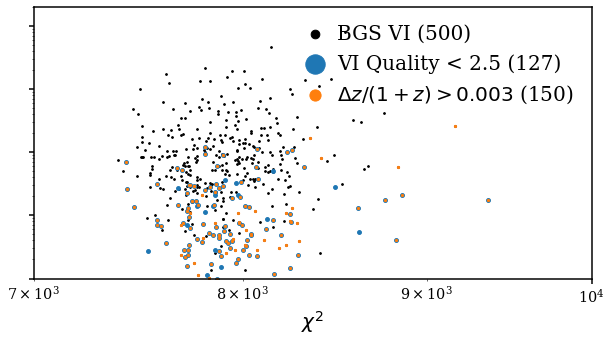

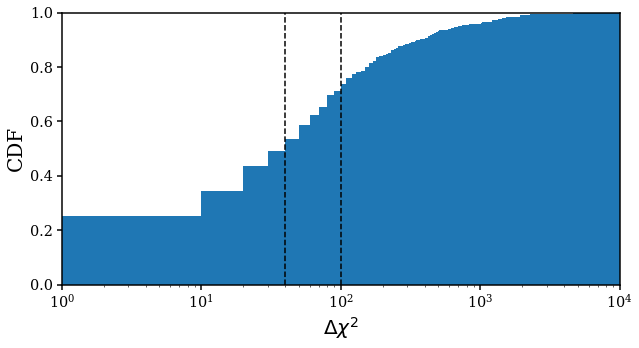

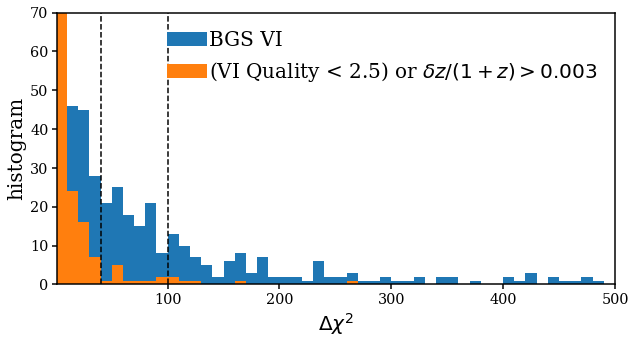

In [66]:
fig = plt.figure(figsize=(10, 5))
sub = fig.add_subplot(111)
sub.scatter(chi2s, dchi2s, s=3, c='k', label='BGS VI (%i)' % len(bad_vi))
sub.scatter(chi2s[bad_vi], dchi2s[bad_vi], c='C0', s=15, label='VI Quality < 2.5 (%i)' % np.sum(bad_vi))
sub.scatter(chi2s[rr_mismatch], dchi2s[rr_mismatch], s=5, c='C1', label='$\Delta z/(1+z) > 0.003$ (%i)' % np.sum(rr_mismatch))
sub.legend(loc='upper right', fontsize=20, handletextpad=0.1, markerscale=5)
sub.set_xlabel(r'$\chi^2$', fontsize=20)
sub.set_xlim(7000., 10000)
sub.set_xscale('log')
sub.set_ylim(1., 2e4)
sub.set_yscale('log')
sub.set_yticklabels([])

fig = plt.figure(figsize=(10, 5))
sub = fig.add_subplot(111)
sub.hist(dchi2s, range=(0, 1e4), cumulative=True, density=True, bins=1000)
sub.plot([40., 40.], [0., 1.], c='k', ls='--')
sub.plot([100., 100.], [0., 1.], c='k', ls='--')
sub.set_xlabel(r'$\Delta \chi^2$', fontsize=20)
sub.set_xlim(1, 1e4)
sub.set_xscale('log')
sub.set_ylabel('CDF', fontsize=20)
sub.set_ylim(0., 1.)

fig = plt.figure(figsize=(10, 5))
sub = fig.add_subplot(111)
sub.hist(dchi2s, range=(0, 1e4), bins=1000, label='BGS VI')
sub.hist(dchi2s[bad_vi | rr_mismatch], range=(0, 1e4), bins=1000, label='(VI Quality < 2.5) or $\delta z/(1+z) > 0.003$')
sub.plot([40., 40.], [0., 100.], c='k', ls='--')
sub.plot([100., 100.], [0., 100.], c='k', ls='--')    
sub.legend(loc='upper right', fontsize=20, handletextpad=0.1)
sub.set_xlabel(r'$\Delta \chi^2$', fontsize=20)
sub.set_xlim(1, 500)
#sub.set_xscale('log')
sub.set_ylabel('histogram', fontsize=20)
sub.set_ylim(0., 70.)    

[]

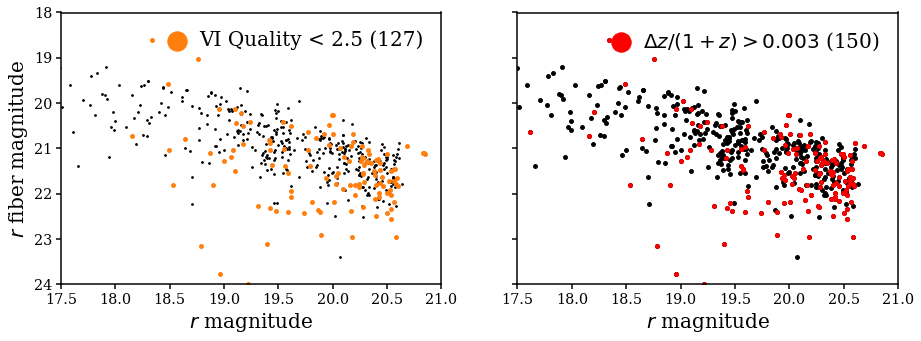

In [31]:
fig = plt.figure(figsize=(15, 5))
sub = fig.add_subplot(121)
sub.scatter(rmags, rfibs, c='k', s=3)
sub.scatter(rmags[bad_vi], rfibs[bad_vi], c='C1', s=15, label='VI Quality < 2.5 (%i)' % np.sum(bad_vi))
sub.legend(loc='upper right', fontsize=20, handletextpad=0.1, markerscale=5)    
sub.set_xlabel(r'$r$ magnitude', fontsize=20)
sub.set_xlim(17.5, 21)
sub.set_ylabel(r'$r$ fiber magnitude', fontsize=20)
sub.set_ylim(24., 18)    
sub = fig.add_subplot(122)
sub.scatter(rmags, rfibs, s=15, c='k')    
sub.scatter(rmags[rr_mismatch], rfibs[rr_mismatch], s=15, c='r', label='$\Delta z/(1+z) > 0.003$ (%i)' % np.sum(rr_mismatch))
sub.legend(loc='upper right', fontsize=20, handletextpad=0.1, markerscale=5)
sub.set_xlabel(r'$r$ magnitude', fontsize=20)
sub.set_xlim(17.5, 21)
sub.set_ylim(24., 18)
sub.set_yticklabels([])    

# There were a few galaxies with very high $\chi^2 > 12000$

In [53]:
galaxy_templates = templates.Template('rrtemplate-galaxy.fits')

DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits


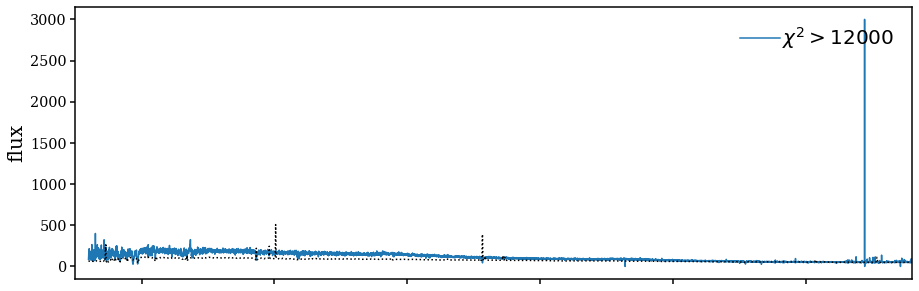

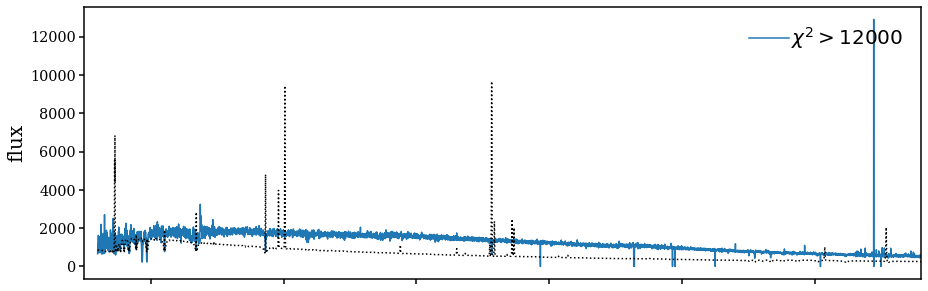

In [56]:
for i in range(np.sum(high_chi2)): 
    fig = plt.figure(figsize=(15, 5))
    sub = fig.add_subplot(111)

    sub.plot(coadd_wave, fluxes[high_chi2,:][i], label='$\chi^2 > 12000$')
    bestfit_template = galaxy_templates.eval(zcoeffs[high_chi2,:][i], coadd_wave, z_rrs[high_chi2][i]) * (1+z_rrs[high_chi2][i])
    sub.plot(coadd_wave, bestfit_template, c='k', ls=':')

    sub.legend(loc='upper right', fontsize=20, handletextpad=0.1, markerscale=5)
    sub.set_xlim(3.5e3, 9.8e3)
    sub.set_xticklabels([])
    sub.set_ylabel(r'flux', fontsize=20)
    #sub.set_ylim(-10, 30)   

# What about objects with `QA flag > 2.5` but `redrock` doesn't flag and gets $z$ wrong

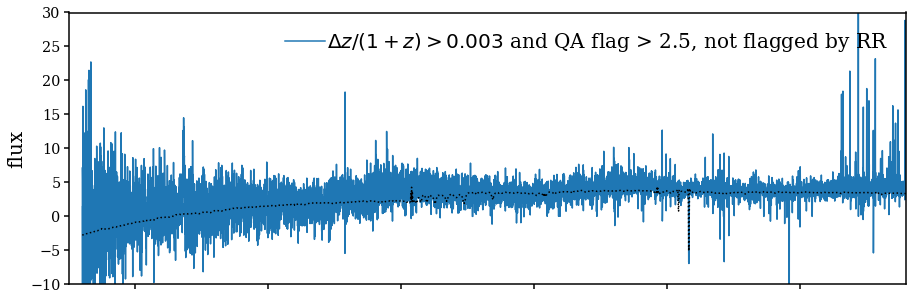

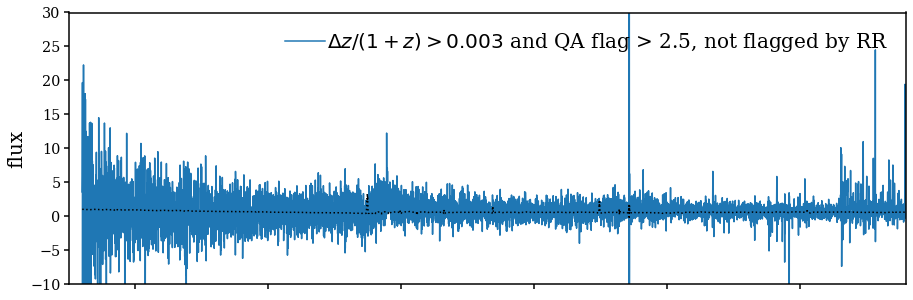

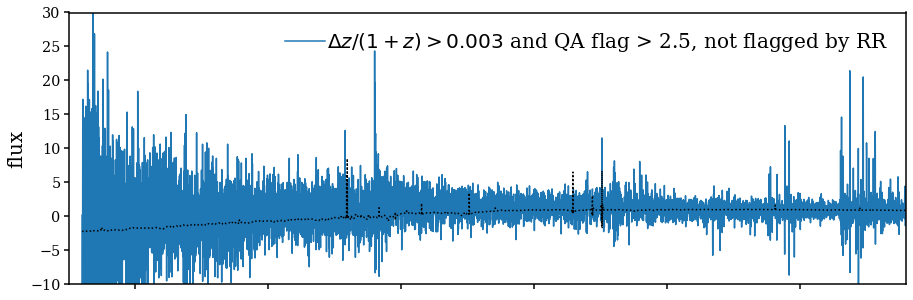

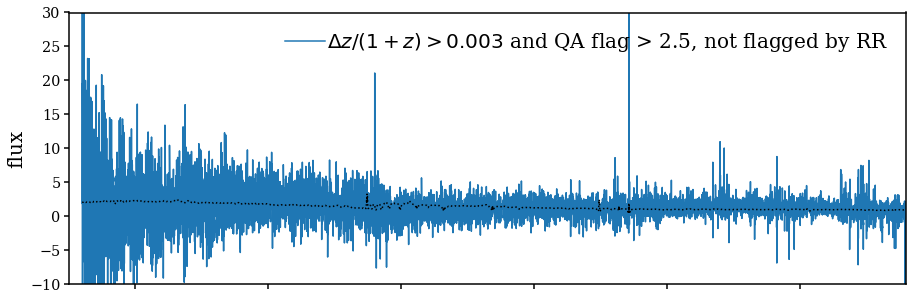

In [80]:
criteria = ~qa_flagged & ~rr_flagged & rr_mismatch
for i in range(np.sum(criteria)): 
    fig = plt.figure(figsize=(15, 5))
    sub = fig.add_subplot(111)

    sub.plot(coadd_wave, fluxes[criteria,:][i], label='$\Delta z / (1+z) > 0.003$ and QA flag > 2.5, not flagged by RR')
    bestfit_template = galaxy_templates.eval(zcoeffs[criteria,:][i], coadd_wave, z_rrs[criteria][i]) * (1+z_rrs[criteria][i])
    sub.plot(coadd_wave, bestfit_template, c='k', ls=':')

    sub.legend(loc='upper right', fontsize=20, handletextpad=0.1, markerscale=5)
    sub.set_xlim(3.5e3, 9.8e3)
    sub.set_xticklabels([])
    sub.set_ylabel(r'flux', fontsize=20)
    sub.set_ylim(-10, 30)   